In [109]:
# Javaria Ahmad
# 3001059
# The goal of this project is to use models for time series forecasting. ARMA and Exponential Smoothing were used.
# References: Pluralsight.com

# imports

%matplotlib inline

import numpy as np
from scipy import stats
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import datetime
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")

In [110]:
# Load into dataframe only the demand data for Product_1159 to see trends for this product.

df_products=pd.read_csv('../data/raw/Historical Product Demand.csv')

df_products = df_products[df_products['Product_Code'] == 'Product_1159']

df_products = df_products['Order_Demand']
df_products = df_products.astype(float)

df_products.head()

16     50000.0
17    100000.0
18     50000.0
19     50000.0
20     50000.0
Name: Order_Demand, dtype: float64

In [111]:
# Replace missing values with NaN

df_products = df_products.replace('?', np.nan)

In [112]:
# Drop rows with NaN values

df_products = df_products.dropna()

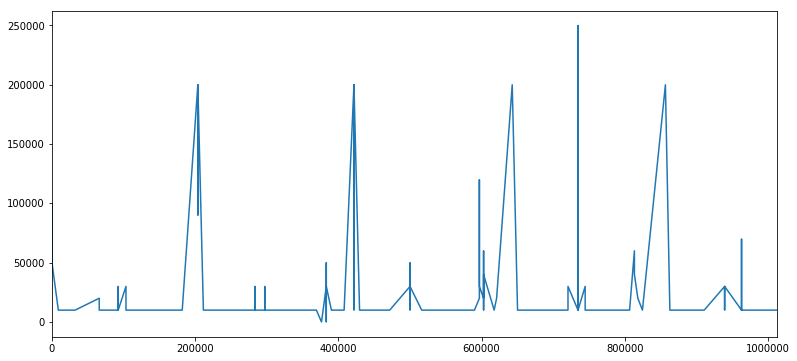

In [113]:
# Plot the data to see if it is stationary. It seems to be.

df_products.plot(figsize=(13,6))

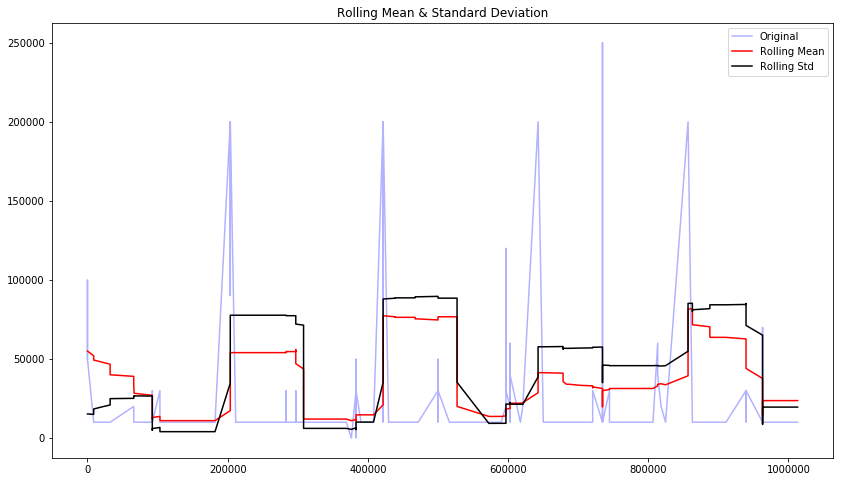

In [114]:
# Plot the rolling mean and standard deviation to double check if the data is stationary.
# Rolling mean and std are within some upper and lower bounds. Time series data is stationary.

rolling_mean=df_products.rolling(window=30,center=False).mean()
rolling_std=df_products.rolling(window=30,center=False).std()

fig=plt.figure(figsize=(14,8))

original=plt.plot(df_products, color='blue',alpha=0.3,label='Original')
mean=plt.plot(rolling_mean, color='red',label='Rolling Mean')
std=plt.plot(rolling_std, color='black',label='Rolling Std')

plt.legend(loc='best')

plt.title('Rolling Mean & Standard Deviation')
plt.show()

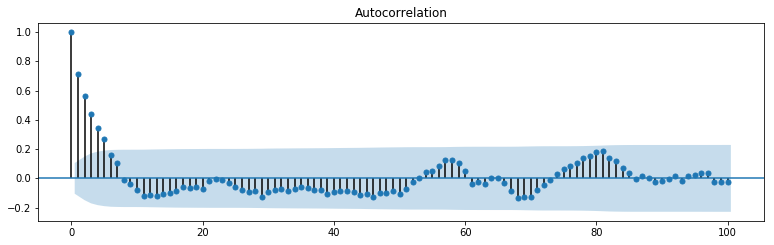

In [115]:
# Extract the values in numpy array form. Then plot autocorrelation function of this data.
# The graph shows that autocorrelation tapers off slowly and no abrupt changes. This is not fit for a Moving Average model.

demand = df_products.values

fig = plt.figure(figsize=(13,8))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(demand, lags=100, ax=ax1)

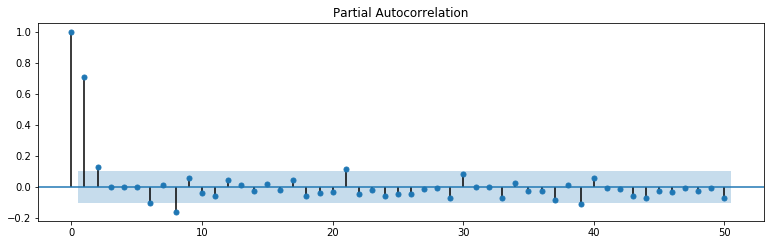

In [116]:
# PACF plot shows an abrupt cut-off after 1 lag. This calls for Auto Regressive model.

fig = plt.figure(figsize=(13,8))
ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_pacf(demand, lags=50, ax=ax2)

In [117]:
# setup multiple ARMA models and chose the best.

arma_model_2 = sm.tsa.ARMA(demand, (2,0)).fit(disp=False)
arma_model_3 = sm.tsa.ARMA(demand, (3,0)).fit(disp=False)
arma_model_5 = sm.tsa.ARMA(demand, (5,0)).fit(disp=False)
arma_model_7 = sm.tsa.ARMA(demand, (7,0)).fit(disp=False)
arma_model_10 = sm.tsa.ARMA(demand, (10,0)).fit(disp=False)

In [118]:
# Compare the scores of different models: aic, bic, hqic. Lower scores are better for all three scores.
# Lag 2 is the best model.

print("Lag 2: ", arma_model_2.aic, arma_model_2.bic, arma_model_2.hqic)
print("Lag 3: ", arma_model_3.aic, arma_model_3.bic, arma_model_3.hqic)
print("Lag 5: ", arma_model_5.aic, arma_model_5.bic, arma_model_5.hqic)
print("Lag 7: ", arma_model_7.aic, arma_model_7.bic, arma_model_7.hqic)
print("Lag 10: ", arma_model_10.aic, arma_model_10.bic, arma_model_10.hqic)

('Lag 2: ', 8335.082226853825, 8350.502514542635, 8341.220693100775)
('Lag 3: ', 8337.076632883649, 8356.351992494661, 8344.749715692336)
('Lag 5: ', 8341.076345788124, 8368.06184924354, 8351.818661720286)
('Lag 7: ', 8341.521224045455, 8376.216871345277, 8355.332773101092)
('Lag 10: ', 8337.736385537732, 8383.99724860416, 8356.151784278582)


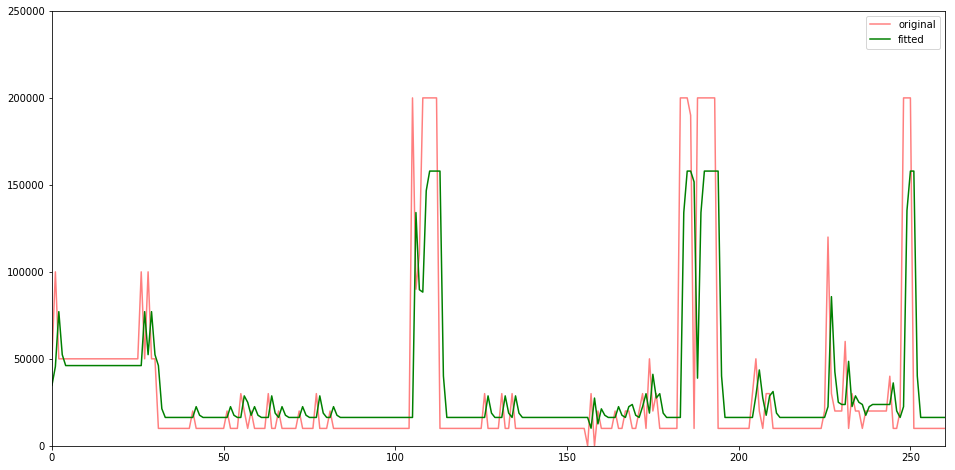

In [119]:
# Visualize fitted values with original values over 260 weeks (5 years). The two values look very close in the plot.

figure = plt.figure(figsize=(16,8))

plt.plot(demand, color='red', alpha = 0.5, label = "original")
plt.plot(arma_model_2.fittedvalues, color='green',label="fitted")
plt.xlim(0,260),plt.ylim(0,250000);
plt.legend()

In [120]:
# Using another model - Exponential Smoothing (Holt-Winters)

exp_smoothing_model = ExponentialSmoothing(demand, seasonal="additive", seasonal_periods=50)

In [121]:
# Model fitting

exp_smoothing_model = exp_smoothing_model.fit()

In [122]:
# Getting smoothing coefficients - alpha

exp_smoothing_model.params['smoothing_level']

0.7401025063058189

In [123]:
# Getting smoothing coefficients - gamma
# The coefficient value of 0 indicates that the model is smooth

exp_smoothing_model.params['smoothing_seasonal']

0.0

In [124]:
# Use the predict method

exp_smoothing_forecast = exp_smoothing_model.predict(start=0, end=260)

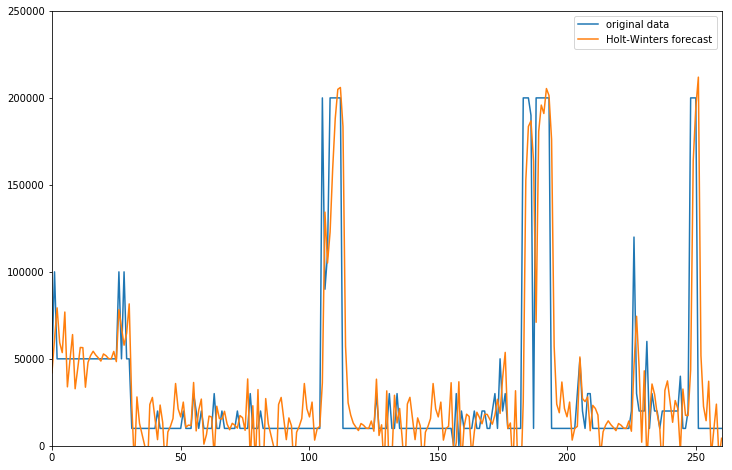

In [125]:
# Visualizing original and predicted values
# The model does a good job in forecasting as shown below

plt.figure(figsize=(12,8))
plt.plot(demand, label='original data')
plt.plot(exp_smoothing_forecast, label='Holt-Winters forecast')
plt.xlim(0,260),plt.ylim(0,250000);
plt.legend()

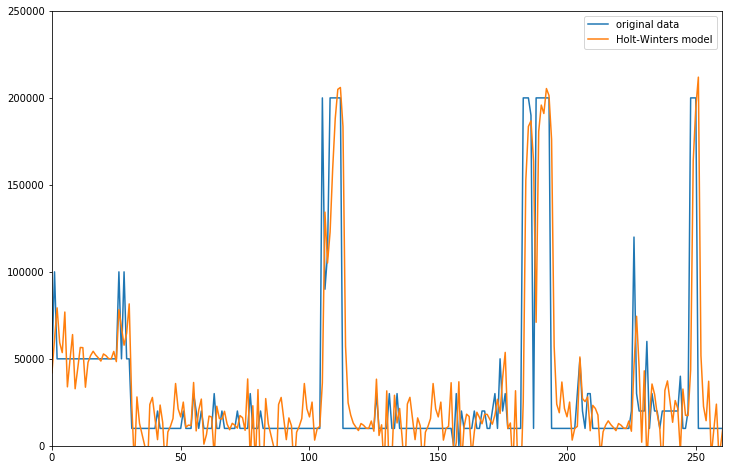

In [126]:
# Now plotting the model values with the original values. It comes out to be a nice match.

plt.figure(figsize=(12,8))
plt.plot(demand, label='original data')
plt.plot(exp_smoothing_model.fittedvalues, label='Holt-Winters model')
plt.xlim(0,260),plt.ylim(0,250000);
plt.legend()

In [127]:
# Both the ARMA and Exponential Smoothing models did a great job per the plot visualizations.